In [2]:
#install transformers
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.6 MB/s eta 0:00:00


In [3]:
#import dependencies
import transformers
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

In [4]:
#define data path
root_path='bbc-text.csv'

In [5]:
#read csv file
df = pd.read_csv(root_path)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [6]:
#Count how many word in every text
df['count'] = df['text'].apply(lambda x: len(x.split()))

<Figure size 800x800 with 0 Axes>

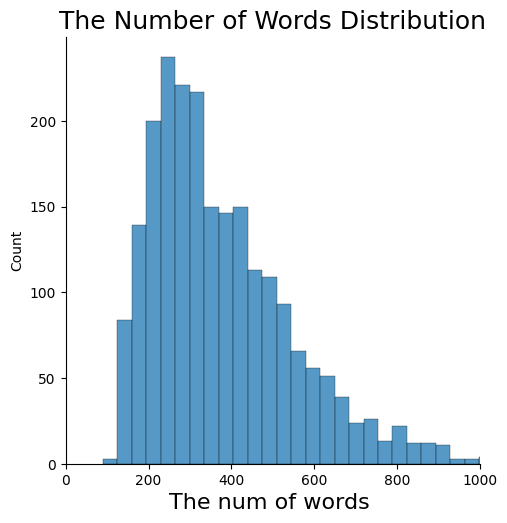

In [7]:
#plot num of words against the number of occurence
plt.figure(figsize= (8, 8))
sns.displot(df['count'])
plt.xlim(0, 1000)
plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

In [8]:
#check the value counts and the values of categories
cat_count=df['category'].value_counts()
cat_names=cat_count.index

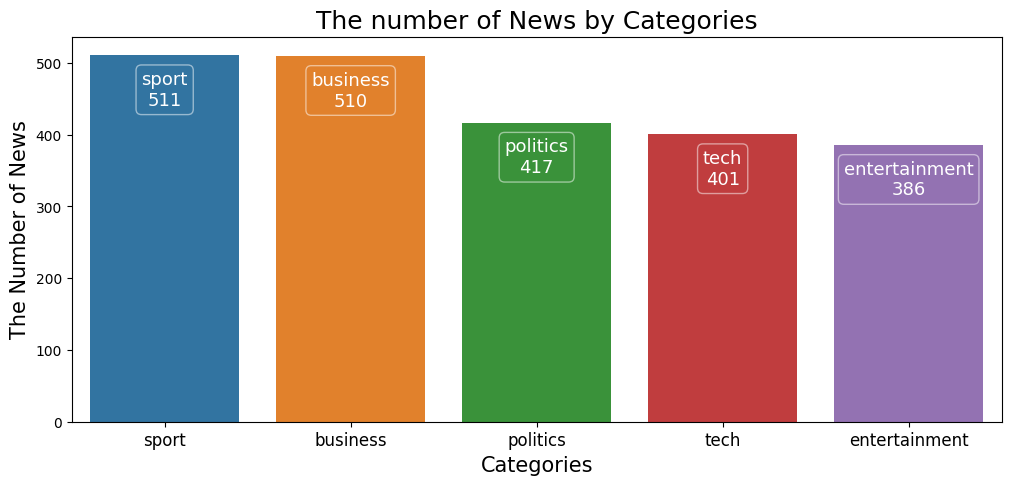

In [9]:
#Plot categories against the value counts
fig = plt.figure(figsize= (12, 5))
ax = fig.add_subplot(111)
sns.barplot(x = cat_names, y = cat_count )
for a, p in enumerate(ax.patches):
    ax.annotate(f'{cat_names[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
plt.xlabel('Categories', size = 15)
plt.ylabel('The Number of News', size= 15)
plt.xticks(size = 12)
plt.title("The number of News by Categories" , size = 18)
plt.show()

In [10]:
#encode categories
df['encoded_cat'] = df['category'].astype('category').cat.codes
df.head()

,category,text,count,encoded_cat
0,tech,tv future in the hands of viewers with home th...,737,4
1,business,worldcom boss left books alone former worldc...,300,0
2,sport,tigers wary of farrell gamble leicester say ...,246,3
3,sport,yeading face newcastle in fa cup premiership s...,341,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,260,1


In [11]:
#create an encoded decoded dict to convert from one form to another
decoded=df['category'].value_counts().index
encoded=df['encoded_cat'].value_counts().index
res=dict(zip(encoded,decoded))

In [12]:
#split data to text and labels
data_texts = df['text'].to_list()
data_labels = df['encoded_cat'].to_list()

In [13]:
#split data to train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )
#split train data to train and val
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, train_size = 0.98, random_state = 0 )


In [14]:
# Use the distilbert pretrained tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#tokenize train and test texts
train_encodings = tokenizer(train_texts, truncation = True, padding = True  )
test_encodings = tokenizer(test_texts, truncation = True, padding = True )

In [15]:
#Convert training data to tf.data.dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

#Convert testing data to tf.data.dataset

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

In [16]:
#import distilbert base uncased and set the num labels to 5
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [17]:
#Set loss function ,optimizrt and metrics that used to compile model
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)

#compile the model
model.compile(optimizer=optimizer,loss=loss_fn,metrics=['accuracy'])

#train the model
model.fit(train_dataset.shuffle(100).batch(16),
              epochs=2,
              batch_size=16,
             )

Epoch 1/2
109/109 [==============================] - 122s 865ms/step - loss: 0.3993 - accuracy: 0.9151
Epoch 2/2
109/109 [==============================] - 98s 896ms/step - loss: 0.0825 - accuracy: 0.9794


In [18]:
#Evaluate model on a test set
model.evaluate(test_dataset.shuffle(100).batch(16))

28/28 [==============================] - 10s 303ms/step - loss: 0.0450 - accuracy: 0.9888


[0.04504068195819855, 0.9887640476226807]

In [19]:
#Save the model to be reused later
save_directory = "/content"

model.save_pretrained(save_directory)

tokenizer.save_pretrained(save_directory)

('/content/tokenizer_config.json',
 '/content/special_tokens_map.json',
 '/content/vocab.txt',
 '/content/added_tokens.json')

In [20]:
#Use the tokenizer and model from the saved dir this time
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)
model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at /content were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
#Create function to classify
def classify(test_text):
    #predict on model
    predict_input = tokenizer_fine_tuned.encode(
        test_text,
        truncation = True,
        padding = True,
        return_tensors = 'tf')
    #logits probs of each class
    output = model_fine_tuned(predict_input)[0]
    #take the argmax val
    prediction_value = tf.argmax(output, axis = 1).numpy()[0]
    #decode the encoded class
    return res[prediction_value]


In [21]:
#Use val_test to test the model of enter news as a text
test_text=val_texts[24]

test_text=''' Ollie Watkins' devastating hat-trick helped ruthless Aston Villa mark their return to European football with a first-leg Europa Conference League play-off demolition of Hibernian.

Hibs hero John McGinn's Easter Road homecoming dominated much of the pre-match build-up, but England striker Watkins will rightly grab the headlines after a phenomenal display at a sell-out Easter Road.

Following a bright start, the Scottish Premiership side could not deal with their clinical Premier League visitors upping the ante as Watkins glanced in a sublime header before nodding in a second at the back post.

Leon Bailey then powered in a close-range header of his own to put Villa - regarded as tournament favourites by many - in complete control at the break in their first European game in 13 years.

Watkins thought the offside flag had denied him a treble just after the interval, but the VAR reviewed his first-time finish past David Marshall, with Douglas Luiz's penalty sealing a record-equalling European win for Unai Emery's side.'''

In [24]:
#classify function take input of news(text) and return the best class for it
classify(test_text)

'sport'